# 图像分类
## 项目简介
利用CNN技术对于图像进行识别，总共有10个类别。通过在训练集进行学习，对测试集进行预测。
Amphibia - 0
Animalia - 1
Arachnida - 2
Aves - 3
Fungi - 4
Insecta - 5
Mammalia - 6
Mollusca - 7
Plantae - 8
Reptilia - 9

## 数据来源
数据集来源是：https://drive.google.com/drive/folders/1dwGzQwooU4PT642faBxBj_CS6OB_FiFE
训练集包含10000张图片，每一种类别都组成了一个单独的文件夹，各有1000张图片。测试由2000张图片组成。


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# 看看MPS能不能用
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("使用MPS设备")
else:
    device = torch.device("cpu")
    print("使用CPU")

# 获取数据
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None, train=True):
        self.img_dir = img_dir
        self.transform = transform
        self.train = train
        self.images = []
        self.labels = []
        if self.train:
            self.classes = sorted([d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))])
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
            
            for cls_name in self.classes:
                cls_folder = os.path.join(img_dir, cls_name)
                for img_name in os.listdir(cls_folder):
                    img_path = os.path.join(cls_folder, img_name)
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        self.images.append(img_path)
                        self.labels.append(self.class_to_idx[cls_name])
        else:
            self.images = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir) if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            self.labels = [-1] * len(self.images)  

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label, os.path.basename(img_path)

train_dir = '/Users/quanzaixuan/Desktop/Assignment/机器学习/animal_recognation_dataset/train'  
test_dir = '/Users/quanzaixuan/Desktop/Assignment/机器学习/animal_recognation_dataset/test'    

# 转换数据
train_transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


train_dataset = CustomDataset(train_dir, transform=train_transform, train=True)
test_dataset = CustomDataset(test_dir, transform=test_transform, train=False)

# 划分训练集和验证集（分层采样）
from sklearn.model_selection import train_test_split

indices = list(range(len(train_dataset)))
train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=train_dataset.labels,
    random_state=42
)


from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 16  # 您可以根据设备性能调整批次大小

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 使用MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# 冻结特征提取层的参数
for param in model.features.parameters():
    param.requires_grad = False

# 修改分类层
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)  # 10个类别

model = model.to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)




使用MPS设备


/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 训练模型
num_epochs = 10
best_val_loss = np.inf
patience = 3
trigger_times = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # 训练
    model.train()
    train_loss = 0.0
    train_correct = 0

    for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)

    epoch_train_loss = train_loss / len(train_indices)
    epoch_train_acc = train_correct.float() / len(train_indices)  
    epoch_train_acc = epoch_train_acc.cpu().numpy()               
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # 验证
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    epoch_val_loss = val_loss / len(val_indices)
    epoch_val_acc = val_correct.float() / len(val_indices)        
    epoch_val_acc = epoch_val_acc.cpu().numpy()                   
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # 早停机制
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        trigger_times = 0
        # 保存最佳模型
        save_dir = '/Users/quanzaixuan/Desktop/Assignment/机器学习'
        save_path = os.path.join(save_dir, 'best_model.pth')
        torch.save(model.state_dict(), save_path)
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("早停！")
            break



Epoch 1/10 - Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1/10 - Validation: 100%|██████████| 24/24 [00:03<00:00,  6.63it/s]


Epoch 1/10
Train Loss: 1.1736, Train Acc: 0.5755
Val Loss: 1.2559, Val Acc: 0.5849


Epoch 2/10 - Validation: 100%|██████████| 24/24 [00:03<00:00,  6.04it/s]


Epoch 2/10
Train Loss: 1.1550, Train Acc: 0.5916
Val Loss: 1.2424, Val Acc: 0.5714


Epoch 3/10 - Validation: 100%|██████████| 24/24 [00:03<00:00,  6.12it/s]


Epoch 3/10
Train Loss: 1.1064, Train Acc: 0.5849
Val Loss: 1.2247, Val Acc: 0.5660


Epoch 4/10 - Validation: 100%|██████████| 24/24 [00:03<00:00,  6.66it/s]


Epoch 4/10
Train Loss: 1.1044, Train Acc: 0.6051
Val Loss: 1.2386, Val Acc: 0.5580


Epoch 5/10 - Validation: 100%|██████████| 24/24 [00:03<00:00,  6.49it/s]


Epoch 5/10
Train Loss: 1.1050, Train Acc: 0.5950
Val Loss: 1.2590, Val Acc: 0.5660


Epoch 6/10 - Validation: 100%|██████████| 24/24 [00:03<00:00,  6.50it/s]

Epoch 6/10
Train Loss: 1.0904, Train Acc: 0.6051
Val Loss: 1.2718, Val Acc: 0.5633
早停！


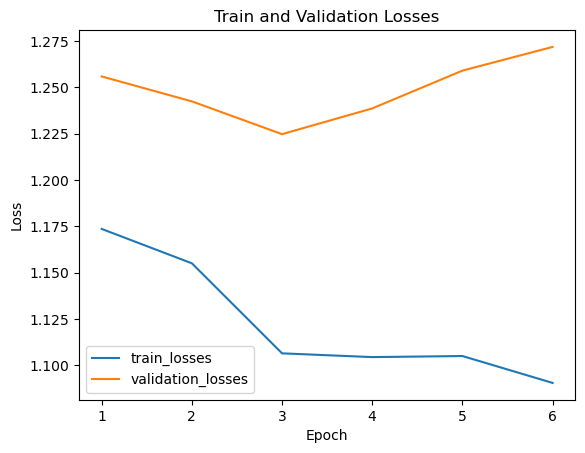

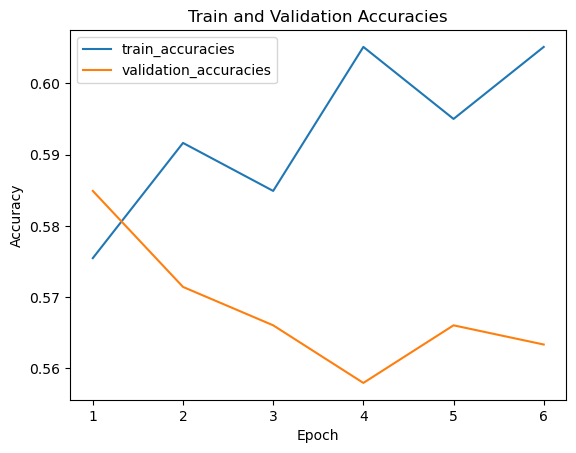

In [12]:
# 可视化训练和验证的损失和准确率
import matplotlib.pyplot as plt

# 绘制损失曲线
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label='train_losses')
plt.plot(range(1, len(val_losses)+1), val_losses, label='validation_losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

# 绘制准确率曲线
plt.figure()
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train_accuracies')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='validation_accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies')
plt.legend()
plt.show()



In [ ]:
# 在测试集上进行预测
save_dir = '/Users/quanzaixuan/Desktop/Assignment/机器学习'
save_path = os.path.join(save_dir, 'best_model.pth')
model.load_state_dict(torch.load(save_path))
model.eval()

predictions = []
filenames = []

with torch.no_grad():
    for inputs, _, names in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        filenames.extend(names)


class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

predicted_labels = [idx_to_class[idx] for idx in predictions]

submission = pd.DataFrame({'filename': filenames, 'label': predicted_labels})

# 将预测结果保存到 submission.csv 文件中
submission_path = os.path.join(save_dir, 'submission.csv')
submission.to_csv(submission_path, index=False)

print("预测完成，结果已保存到 submission.csv")

/var/folders/k8/s4d45bd12m58z93br_z4dxh40000gn/T/ipykernel_54654/460552380.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
P

预测完成，结果已保存到 submission.csv
